# MCMC with fixed auxiliary variables and rejection-free samplers

In this work, we develop an MCMC algorithm that targets a density $p: \mathcal{X} \to \mathbb{R}^{+}$
but where the auxiliary variables,
such as probabilities of acceptance in the Hastings' ratio and draws from the proposal distribution,
are fixed.
The only randomness left in the algorithm is that of the initial set of points $x_0 \sim q_0$.

In full generality, the algorithm receives an update function

$$
    \rho: \mathcal{X} \to \mathcal{X} \\
    \qquad x_t \mapsto x_{t+1}
$$

that deterministically updates the current state of the chain.
The function might depend on auxiliary variables, such as acceptance probabilities,
but these are assumed fixed once the chain starts running.


## Special case: Unadjusted Langevin algorithm (ULA)

In the ULA algorithm, 
we construct a discrete approximation to a Langevin diffusion that has the target density $p$
as stationary distribution.
For a given step size $\tau$, the ULA update funcion is given by

$$
    \rho_{\mathrm{ULA}}(x_t) = x_t + \tau \nabla \log p(x_t) + \sqrt{2 \tau} \epsilon_t,
$$

where $\epsilon_t \sim \mathcal{N}(0,I)$ for all $t$. 
Note that all of the Gaussian shifts $\epsilon_1,\epsilon_2,\dots$ are assumed to be fixed once that
chain starts running.

A closely-related algorithm is the Metropolis-adjusted Langevin algorithm (MALA),
which considers $\rho_{\mathrm{ULA}}(x_t)$ as a Hastings proposal.
As per ML folk wisdom, MALA tends to mix better/faster than ULA due to the rejection step.
We compare the fixed-ULA algorithm with MALA.

## Implementation

Here, we implement the algorithm and explore its behaviour as the number of steps $T \to \infty$,
as well as the impact of the (fixed) auxiliary variables.
We denote by $q_t$ the underlying distribution of the Markov chain run for $t$ steps.

First, we develop code to implement a generic MCMC algorithm with fixed auxiliary variables.
The algorithm receives a generic update function&mdash;used to update the state variables at each 
timestep&mdash;and fixed acceptance probabilities.

In [1]:
# preamble
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [2]:
#########################
#########################
# MCMC fixed aux vars ###
#########################
#########################
def mcmc_fixed_aux(x, T, logp, rho):
    # run MCMC chain with fixed auxiliary variables
    #
    # input:
    # x       : (N,K) array, initial locations for sampling; N number of samples, K dimension
    # T       : integer, number of steps to run chain for
    # logp    : function, target log density
    # rho     : function, deterministic x update for each timestep
    #
    # output:
    # x       : (N,K) array with MCMC samples
    for t in range(T): x = rho(x,t,logp)
    return x

## Gaussian toy example

We first consider a univariate example where $p(x) = \mathcal{N}(x \, | \, 100,1)$
and hand-code the score function $\nabla \log p(x)$&mdash;although we could also use autodiff
for a more black-box implementation.
We initialize the algorithm by drawing a sample of size $N=1,000$ from a standard Gaussian distribution.

For ULA and MALA, we set the step size to $\tau = 0.05$,
which ensures that a sufficiently large number of steps are needed to discover the mode of the target.
and generate $\epsilon_1,\epsilon_2,\dots \overset{\mathrm{iid}}{\sim} \mathcal{N}(0,1)$
before starting the chain.

### Measuring convergence

For any given $T$, each algorithm results in a sample from $q_T$.
To quantify the accuracy of this sample, we would ideally use some divergence $\mathrm{D}(q_T,p)$.
However, because we do not have access to the density $q_t(\cdot)$ for MALA (although we do for ULA),
we cannot use most popular divergences (e.g., $f$-divergences).
To address this, we instead compute the Kolmogorov-Smirnov statistic

$$
   D_T = \sup_x |P(x)-Q_T(x)| > 0,
$$

where $P$ and $Q_T$ are the (empirical) cdfs of $p$ and $q_T$, respectively.
Low values of $D_T$ indicate that $q_T \approx p$.
If $D_T$ decreases as we increase $T$,
then that suggests that the fixed auxiliary variables and
random initial sample do not impact the distribution of $q_T$.

In [37]:
#########################
#########################
###  problem settings ###
#########################
#########################
np.random.seed(123)

# gaussian target
mu_p = 100
logp = lambda x : -0.5*np.sum((x-mu_p)**2,axis=-1)-0.5*x.shape[1]*np.log(2*np.pi)

# set problem's dimensions
N = 1000                 # number of MCMC particles
K = 1                    # dimension
x = np.random.randn(N,K) # initial points ~ N(0,1) 

# auxiliary variables
maxT = 100000           # max number of MCMC steps
v = np.random.randn(N,maxT)
u = np.random.rand(N,maxT)

# rwmh rho
def rwmh_update(x,t,logp):
    tmp_x = x+v[:,t][:,np.newaxis]                    # add gaussian shifts
    logratio = logp(tmp_x)-logp(x)                    # log hastings ratio, assuming symmetric proposal
    swaps = np.log(u[:,t]) < np.minimum(0, logratio)  # indices with accepted proposals
    x[swaps,:] = tmp_x[swaps,:]                       # update accepted proposals
    return x

# ula rho
grad_logp = lambda x : -(x-mu_p)
tau = 0.8
xi = np.random.randn(N,maxT)
def ula_update(x,t,logp): return x + tau*grad_logp(x) + np.sqrt(2*tau)*xi[:,t][:,np.newaxis]

# mala rho
mala_logq = lambda x,y : -0.25*tau*np.sum((x-y-tau*grad_logp(y))**2, axis=-1)
def mala_update(x,t,logp):
    tmp_x = x + tau*grad_logp(x) + np.sqrt(2*tau)*xi[:,t][:,np.newaxis]
    logratio = logp(tmp_x)-logp(x) + mala_logq(x,tmp_x)-mala_logq(tmp_x,x)
    swaps = np.log(u[:,t]) < np.minimum(0, logratio)
    x[swaps,:] = tmp_x[swaps,:]
    return x

In [38]:
#########################
#########################
###    simulation     ###
#########################
#########################

# settings
Ts = np.round(10.**np.arange(0.75,3.25,0.125)).astype(int)
ula_samples = np.zeros((Ts.shape[0], N))
mala_samples = np.zeros((Ts.shape[0], N))
ula_kss = np.zeros((Ts.shape[0], N))
mala_kss = np.zeros((Ts.shape[0], N))
p_sample = mu_p+np.random.randn(N)

for k in range(Ts.shape[0]):
    print(str(k+1) + '/' + str(Ts.shape[0]), end='\r')
    
    # run chain and save samples    
    tmp_ula_sample = mcmc_fixed_aux(x, Ts[k], logp, ula_update) 
    ula_samples[k,:] = np.squeeze(tmp_ula_sample)
    
    tmp_mala_sample = mcmc_fixed_aux(x, Ts[k], logp, mala_update) 
    mala_samples[k,:] = np.squeeze(tmp_mala_sample)
    
    # do ks test and save results    
    tmp_ks = stats.kstest(np.squeeze(tmp_ula_sample), p_sample)
    ula_kss[k,0] = tmp_ks[0]
    ula_kss[k,1] = tmp_ks[1]
    
    tmp_ks = stats.kstest(np.squeeze(tmp_mala_sample), p_sample)
    mala_kss[k,0] = tmp_ks[0]
    mala_kss[k,1] = tmp_ks[1]
# end simulation    

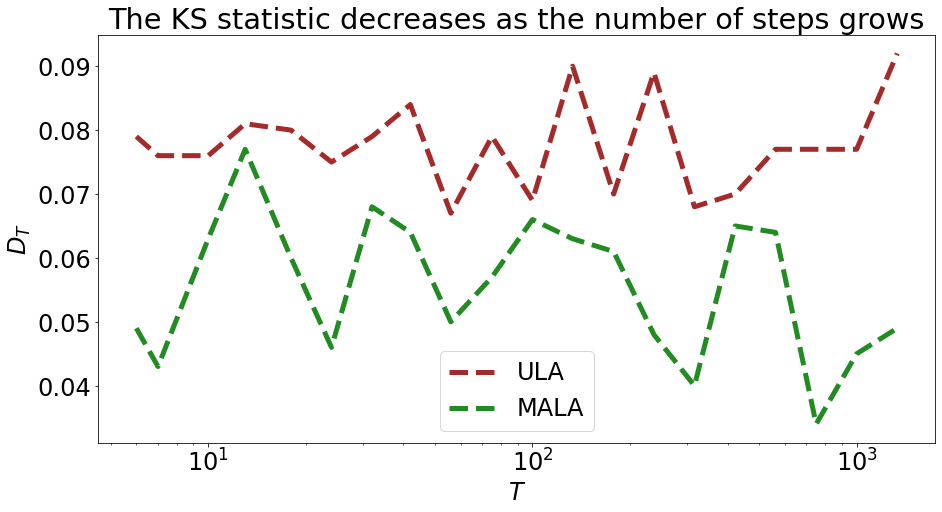

In [39]:
#########################
#########################
###      KS plot      ###
#########################
#########################
f, ax = plt.subplots()
plt.plot(Ts,ula_kss[:,0], color = 'brown', lw = 5, label = 'ULA', ls = 'dashed')
plt.plot(Ts,mala_kss[:,0], color = 'forestgreen', lw = 5, label = 'MALA', ls = 'dashed')
plt.xlabel(r'$T$')
plt.ylabel(r'$D_T$')
plt.title(r'The KS statistic decreases as the number of steps grows')
plt.legend()
ax.set_xscale('log')

As with RWMH a couple of weeks ago, both samplers cause the DS statistic to decrese.
Notably, ULA seems to achieve smaller values of the statistic,
which is surprising since the rejection step cause MALA to mix better.
We will explore this behaviour later on.

In [40]:
#########################
#########################
###   KDE fitting     ###
#########################
#########################
ls = np.linspace(-4,mu_p+5,1000)
kdes = np.zeros((4,ls.shape[0]))
idx = np.array([1,5,9,13])
for i in range(4): kdes[i,:] = stats.gaussian_kde(np.squeeze(ula_samples[idx[i],:]), bw_method = 0.25).evaluate(ls)

Text(0.5, 1.0, 'Densities approach $p$ as $T$ grows')

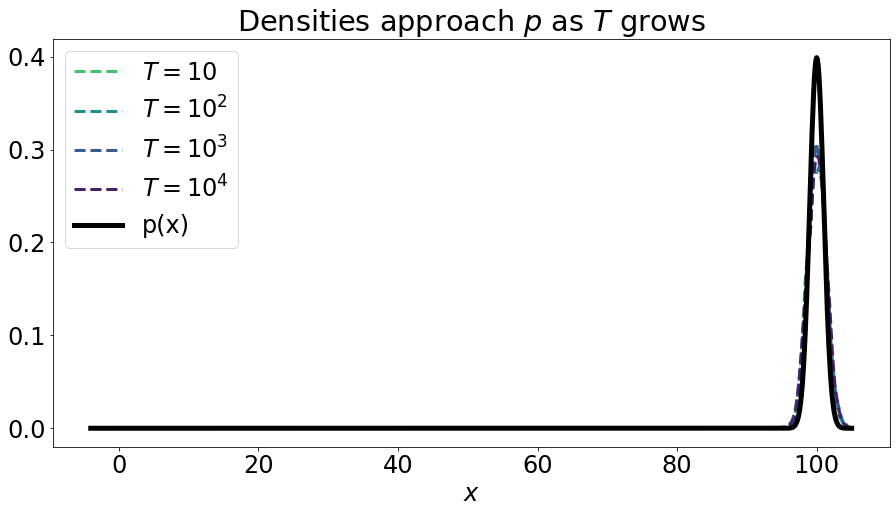

In [41]:
#########################
#########################
###    KDE plot       ###
#########################
#########################
colors = np.array(['#47C16EFF', '#21908CFF', '#365D8DFF', '#481F70FF', '#C7E020FF'])

plt.plot(ls, kdes[0,:], ls = 'dashed', color = colors[0], lw = 3, label = r'$T = 10$')
plt.plot(ls, kdes[1,:], ls = 'dashed', color = colors[1], lw = 3, label = r'$T = 10^2$')
plt.plot(ls, kdes[2,:], ls = 'dashed', color = colors[2], lw = 3, label = r'$T = 10^3$')
plt.plot(ls, kdes[3,:], ls = 'dashed', color = colors[3], lw = 3, label = r'$T = 10^4$')
plt.plot(ls, np.exp(logp(ls[:,np.newaxis])), color = 'black', label = 'p(x)', lw = 5)
plt.legend()
plt.xlabel(r'$x$')
plt.title(r'Densities approach $p$ as $T$ grows')

### Importance of fixed auxiliary variables

As before, we now study the impact that auxiliary variables have on the distribution of the Markov chain.
We generate multiple initial values, run the chain for $T = 100$ steps&mdash;which seemed large enough
from our last analysis&mdash;and plot the distribution of the KS test statistic.

In [44]:
#########################
#########################
###    simulation     ###
#########################
#########################

# settings
M = 1000
initial_seed = 123
T = 100
ula_samples2 = np.zeros((M,N))
ula_kss2 = np.zeros((M,2))
mala_samples2 = np.zeros((M,N))
mala_kss2 = np.zeros((M,2))

np.random.seed(initial_seed)
x0 = np.random.randn(N,K)


# ula rho
grad_logp = lambda x : -(x-mu_p)
tau = 0.8
# mala rho
mala_logq = lambda x,y : -0.25*tau*np.sum((x-y-tau*grad_logp(y))**2, axis=-1)


for m in range(M):
    print(str(m+1) + '/' + str(M), end='\r')
    
    # generate auxiliary variables and define update rules
    np.random.seed(initial_seed+m)
    u = np.random.rand(N,T)
    xi = np.random.randn(N,T)
    def ula_update(x,t,logp): return x + tau*grad_logp(x) + np.sqrt(2*tau)*xi[:,t][:,np.newaxis]
    def mala_update(x,t,logp):
        tmp_x = x + tau*grad_logp(x) + np.sqrt(2*tau)*xi[:,t][:,np.newaxis]
        logratio = logp(tmp_x)-logp(x) + mala_logq(x,tmp_x)-mala_logq(tmp_x,x)
        swaps = np.log(u[:,t]) < np.minimum(0, logratio)
        x[swaps,:] = tmp_x[swaps,:]
        return x
        
    # run chain, and save results
    ula_tmp_sample = mcmc_fixed_aux(x0, T, logp, ula_update) 
    ula_samples2[m,:] = np.squeeze(ula_tmp_sample)
    
    mala_tmp_sample = mcmc_fixed_aux(x0, T, logp, mala_update) 
    mala_samples2[m,:] = np.squeeze(mala_tmp_sample)
    
    # do ks test and save results
    tmp_ks = stats.kstest(np.squeeze(ula_tmp_sample), p_sample)
    ula_kss2[m,0] = tmp_ks[0]
    ula_kss2[m,1] = tmp_ks[1]
    
    tmp_ks = stats.kstest(np.squeeze(mala_tmp_sample), p_sample)
    mala_kss2[m,0] = tmp_ks[0]
    mala_kss2[m,1] = tmp_ks[1]
# end simulation

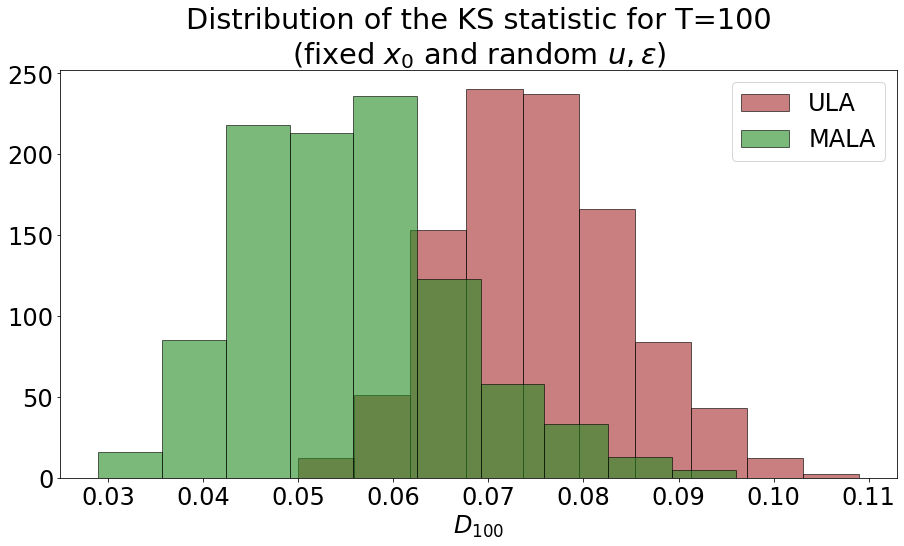

In [45]:
############################
############################
### plot KS distribution ###
############################
############################
plt.hist(ula_kss2[:,0], bins = 10, ec = 'black', color = 'brown', alpha = 0.6, label = 'ULA');
plt.hist(mala_kss2[:,0], bins = 10, ec = 'black', color = 'forestgreen', alpha = 0.6, label = 'MALA');
plt.xlabel(r'$D_{100}$')
plt.title('Distribution of the KS statistic for T=100\n(fixed $x_0$ and random $u,\epsilon$)');
plt.legend()

We again see that ULA performs better, 
although its distribution has a considerably heavy right tail.
This is in contrast with the distribution of the KS statistic for MALA,
which although higher on average is much more concentrated.
Hence, although ULA seemingly performs better than MALA usually,
this comes at a cost since ULA is more likely to perform worse.

### Distribution of the state of ULA algorithm

As seen in the accompanying notes, 
we can find the density $q_T$ of the state of the ULA chain after $T$ iterations in closed form.
Specifically, letting $\phi = (1-\tau)^{-1}$ be the Jacobian of the inverse transformation
in the ULA update rule, we have that

$$
     q_T(x) = \phi^T  q_0 \left(
    \phi^T x - \tau \mu \sum_{t=1}^T \phi^t
    - \sqrt{2\tau} \sum_{t=1}^T \epsilon_t \phi^t
    \right),
$$

where $q_0$ is the density of the distribution from which the initial sample $x_0$ is drawn.
In our case, this corresponds to a standard Gaussian. 

Because the log density is computationally more amenable, we note that

$$
    \log q_T(x) = T \log \phi + 
    \log q_0 \left(
    \phi^T x - \tau \mu \sum_{t=1}^T \phi^t
    - \sqrt{2\tau} \sum_{t=1}^T \epsilon_t \phi^t
    \right).
$$

First we develop code to evaluate the log density.

In [10]:
def logqT(x, tau, epsilon, mu):
    # log density of the state distribution of ULA after T steps
    # input:
    # x        : (N,K) array, log density will be evaluated at x
    # tau      : positive real, step size for MALA update
    # epsilon  : (T,) array, (fixed) Gaussian shifts
    # mu       : real, mean of target density
    #
    # output:
    # (N,) array, log density evaluated at x
    
    K = x.shape[1]
    T = epsilon.shape[0]
    phi = 1/(1-tau)
    phi_powers = np.power(phi, np.arange(1,T+1))
    logq0 = lambda x : -0.5*np.sum(x**2,axis=-1)-0.5*K*np.log(2*np.pi)
    return T*np.log(phi) + logq0(x*phi**T - tau*mu*np.sum(phi_powers) - np.sqrt(2*tau)*np.sum(phi_powers*epsilon))
    

#### Relationship between $\tau$ and the Jacobian of the inverse transform

Just to better understand how one changes with the other.
Because 

$$
    \phi = (1-\tau)^{-1}
$$

we highlight that there will be an asysmptote at $\tau=1$.

Below we show the relationship between the two quantities.

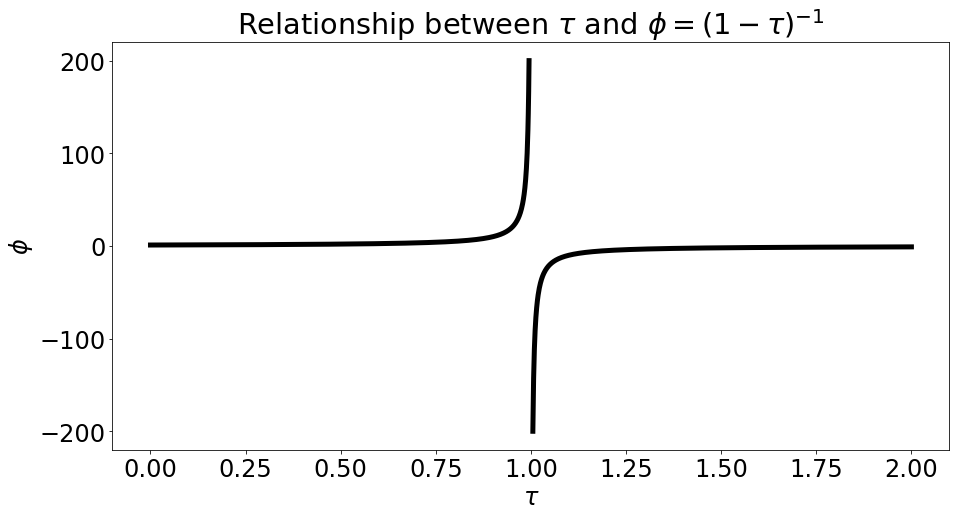

In [11]:
taus1 = np.linspace(0.,0.995,1000)
phis1 = 1./(1.-taus1)
taus2 = np.linspace(1.005,2.,1000)
phis2 = 1./(1.-taus2)
plt.plot(taus1, phis1, lw = 5, color = 'black')
plt.plot(taus2, phis2, lw = 5, color = 'black')
plt.xlabel(r'$\tau$');
plt.ylabel(r'$\phi$');
plt.title(r'Relationship between $\tau$ and $\phi = (1-\tau)^{-1}$');

We see that $\phi$ increases (decreases) rapidly as $\tau$ approaches 1 from the left (right).
In our simulation, we used a step size of $\tau = 0.05$, 
which results in a Jacobian of around $1.05$.

#### The density

We now plot the density $q_T$ for multiple values of $T$
agains the target density $p$.

Text(0.5, 1.0, 'Density $q_T$ as $T$ increases')

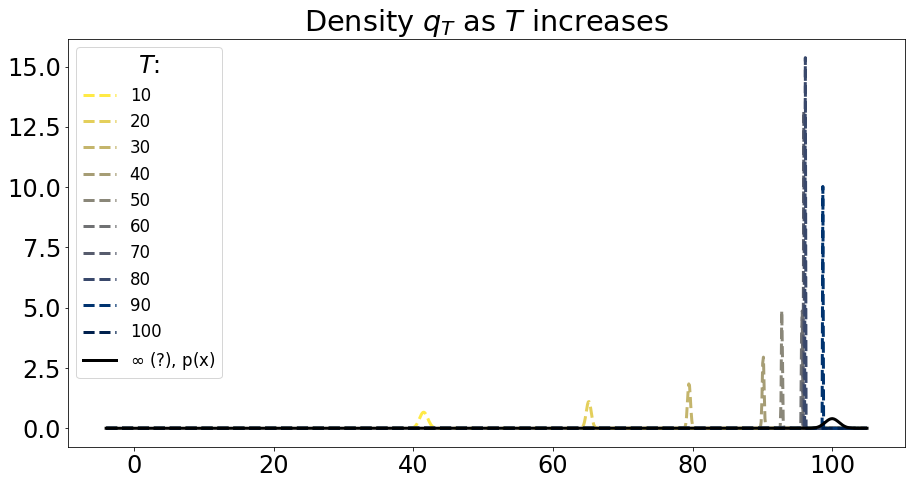

In [12]:
Ts = np.linspace(10,100,10).astype(int)
ls = np.linspace(-4,mu_p+5,1000)
colors = ["#00204DFF","#00336FFF","#39486BFF","#575C6DFF","#707173FF",
          "#8A8779FF","#A69D75FF","#C4B56CFF","#E4CF5BFF","#FFEA46FF"]
for i in range(Ts.shape[0]):
    plt.plot(ls, np.exp(logqT(ls[:,np.newaxis], 0.05, xi[0,0:Ts[i]], mu_p)),
            lw = 3, linestyle = 'dashed', color = colors[Ts.shape[0]-1-i], label = str(Ts[i]))

plt.plot(ls, np.exp(logp(ls[:,np.newaxis])), color = 'black', label = r'$\infty$ (?), p(x)', lw = 3)
plt.legend(title = r'$T$:', fontsize = 'x-small')
plt.title(r'Density $q_T$ as $T$ increases')

The results are not what we expect. 
While the densities $q_T$ do shift towards 100,
their standard deviation decreases.
This results in peaky distributions.

The most likely culprit is a bug in the code.
We investigate that now by looking at the behaviour of different bits of the density.

### Debugging

First we try to understand the shifts inside the density, i.e.,

$$
    \phi^T x - \tau \mu \sum_{t=1}^T \phi^t
    - \sqrt{2\tau} \sum_{t=1}^T \epsilon_t \phi^t.
$$

We consider a special case: when $x = \mu$, the target mean.
This is motivated by the fact that we expect $q_T$ to be similar to $p$,
whose mode is precisely at $\mu$.
Hence, we would expect the shift inside $q_0$ to become close to
the mean of the reference, namely, 0:

$$
    \phi^T \mu - \tau \mu \sum_{t=1}^T \phi^t
    - \sqrt{2\tau} \sum_{t=1}^T \epsilon_t \phi^t \to 0
$$

as $T \to \infty$ so that $q_0$ of that shift is maximized.

We start by plotting the shift as a function of $T$ below. 

In [13]:
def shift(x, tau, epsilon, mu): 
    T = epsilon.shape[0]
    phi = 1/(1-tau)
    phi_powers = np.power(phi, np.arange(1,T+1))
    return x*phi**T - tau*mu*np.sum(phi_powers) - np.sqrt(2*tau)*np.sum(phi_powers*epsilon)

Text(0, 0.5, 'shift inside $q_0$')

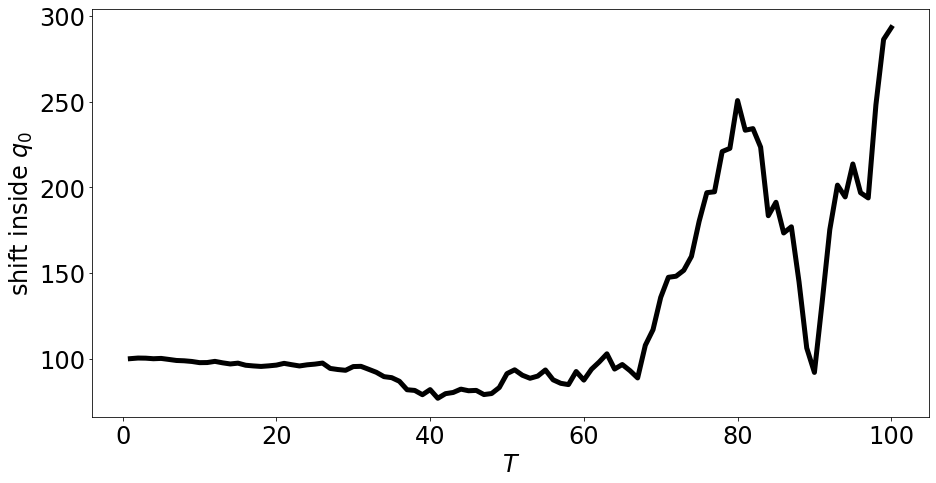

In [14]:
Tls = np.arange(1,101)
shifts = np.zeros(100)
for t in range(shifts.shape[0]):
    shifts[t] = shift(mu_p, 0.05, xi[0,0:t], mu_p)

plt.plot(Tls, shifts, lw = 5, color = 'black')
#plt.plot(Tls, -0.5*shifts**2-0.5*np.log(2*np.pi), lw = 5, color = 'black')
plt.xlabel(r'$T$')
plt.ylabel(r'shift inside $q_0$')

We see that the behaviour is unlike what we expected, 
since the overall magnitude of the shift increases&mdash;we would expect it to become close to 0.

To pinpoint which term is causing trouble,
we plot each term (as a function of $T$) below.

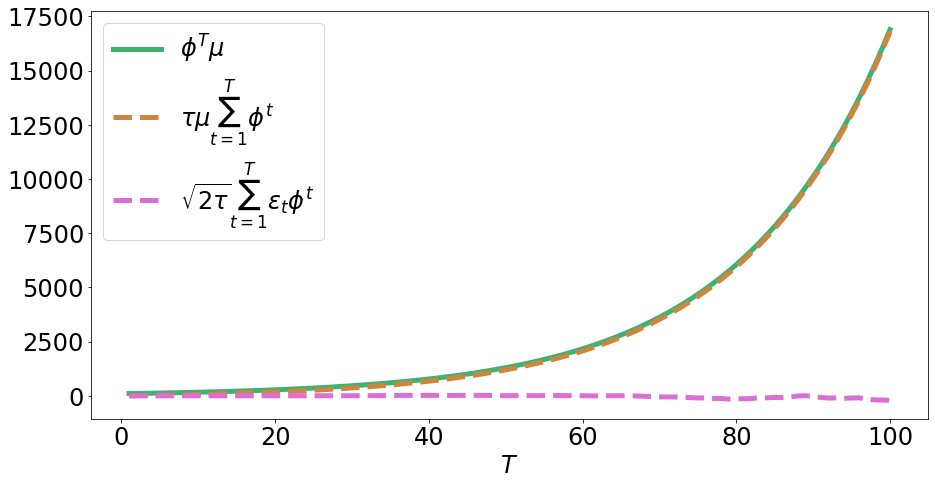

In [21]:
Ts = np.arange(1,101)
phiT = np.power(1./0.95, Ts)
plt.plot(Ts,mu_p*phiT, lw = 5, color = 'mediumseagreen',
         label = r'$\phi^T \mu$')
plt.plot(Ts,0.05*mu_p*np.cumsum(phiT), lw = 5, linestyle = 'dashed', color = 'peru', 
         label = r'$\tau \mu \sum_{t=1}^T \phi^t$')
plt.plot(Ts,np.sqrt(2*0.05)*np.cumsum(phiT*xi[0,:]), lw = 5, linestyle = 'dashed', color = 'orchid',
         label = r'$\sqrt{2\tau} \sum_{t=1}^T \epsilon_t \phi^t$')
#plt.plot(mu_p*phiT - 0.05*mu_p*np.cumsum(phiT) - np.sqrt(2*0.05)*np.cumsum(phiT*xi[0,:]),
#        lw = 5, color = 'black', label = 'sum')
plt.xlabel(r'$T$')
plt.legend()

This is interesting.
The first two terms grow at the same exponential rate,
and when subtracting them they very likely end up contributing little.
Because their magnitude is way larger than the third term,
we plot the latter one individually below.




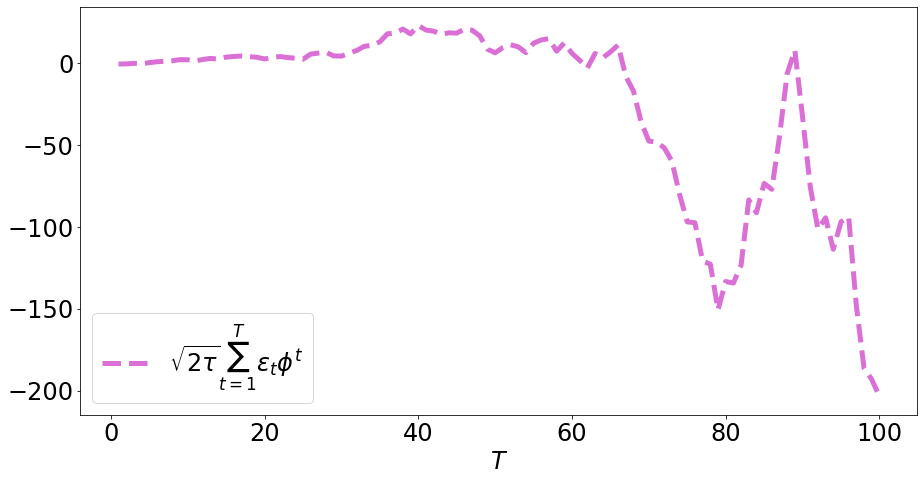

In [22]:
Ts = np.arange(1,101)
phiT = np.power(1./0.95, Ts)
plt.plot(Ts,np.sqrt(2*0.05)*np.cumsum(phiT*xi[0,:]), lw = 5, linestyle = 'dashed', color = 'orchid',
         label = r'$\sqrt{2\tau} \sum_{t=1}^T \epsilon_t \phi^t$')
plt.xlabel(r'$T$')
plt.legend()

This is pretty similar to the (negative of the) trend that we observed in the plot of the shifts,
which means that this is the likely cause of trouble.
Each random deviate $\epsilon_t$ comes from a standard Gaussian distribution,
which means that their magnitudes are controlled. We can verify this by displaying
a traceplot of the Gaussian shifts:



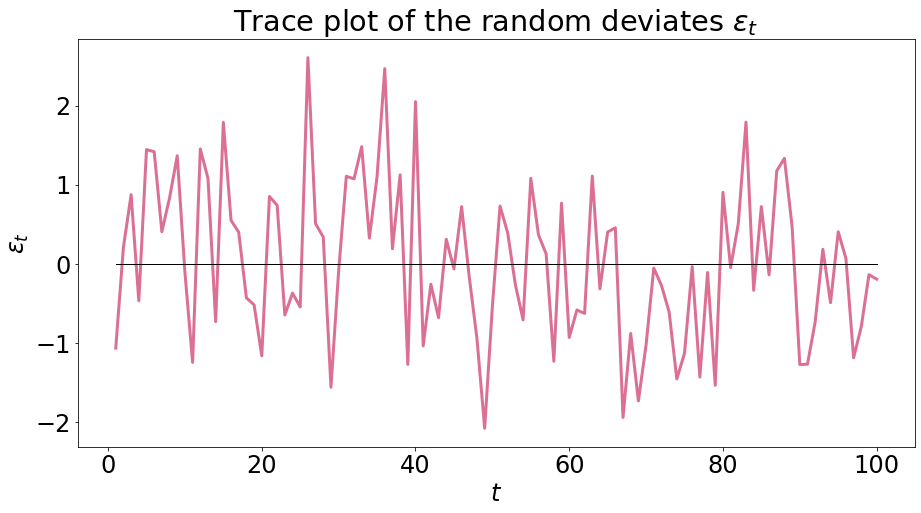

In [17]:
plt.plot(np.arange(1,101),xi[0,:], lw = 3, color = 'palevioletred')
plt.plot(np.arange(1,101), np.zeros(100), lw = 1, color = 'black')
#plt.plot(np.arange(1,101), -3*np.ones(100), lw = 1, color = 'black', linestyle = 'dashed')
#plt.plot(np.arange(1,101), 3*np.ones(100), lw = 1, color = 'black', linestyle = 'dashed')
plt.xlabel(r'$t$')
plt.ylabel(r'$\epsilon_t$')
plt.title('Trace plot of the random deviates $\epsilon_t$');

The traceplot looks fine, which suggests that the random deviates are not the source of trouble.

We conclude by studying the behaviour of $\phi^T$.
This is the last likely culprit of the erroneous behaviour,
since it corresponds to the coefficients multiplying the Gaussian shifts.
First for $\tau=0.05$, as in our simulation,
we plot the behaviour of $\phi^T$ as a function of $T$.

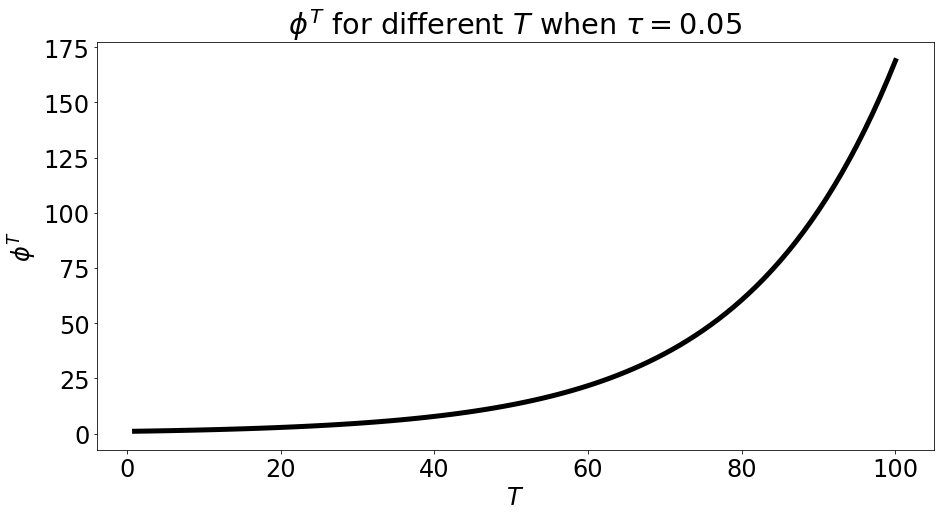

In [18]:
Ts = np.arange(1,101)
phiT = np.power(1./0.95, Ts)
plt.plot(Ts,phiT, lw = 5, color = 'black')
plt.xlabel(r'$T$')
plt.ylabel(r'$\phi^T$');
plt.title(r'$\phi^T$ for different $T$ when $\tau=0.05$');

As expected, the growth is exponential because $\phi > 1$.
This, however, suggests that the sum

$$
    \sqrt{2\tau} \sum_{t=1}^T \epsilon_t \phi^t
$$

will tend to grow as $T$ grows,
since the coefficients are all of the same magnitud and $\tau$ is fixed,
so that the terms $\phi^t$ add more and more.

To understand how different values of $\tau$ might affect this behaviour,
we now study how $\phi^T$ changes for multiple $T$ and $\tau$ as well.

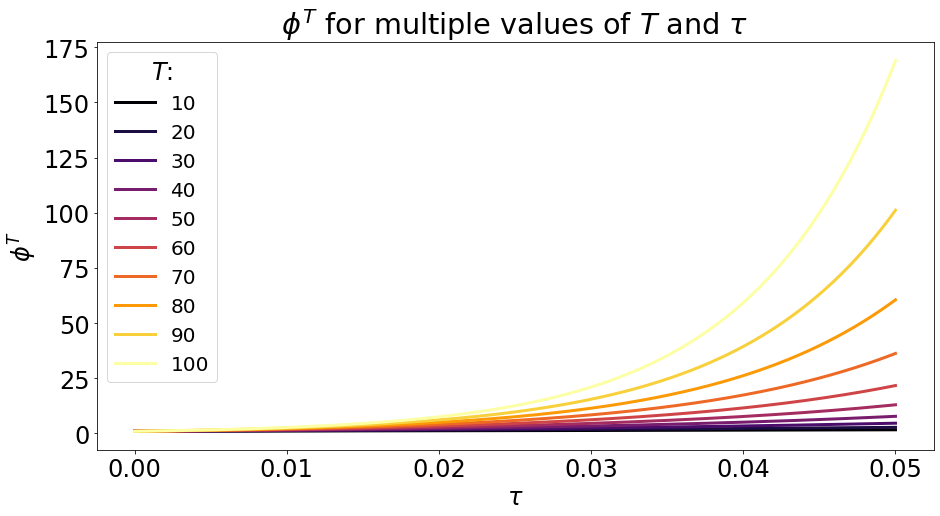

In [19]:
taus = np.linspace(0., 0.05, 1000)
phis = 1./(1.-taus)
exponents = np.linspace(10,100,10)
colors = ["#000004FF","#1B0C42FF","#4B0C6BFF","#781C6DFF","#A52C60FF",
          "#CF4446FF","#ED6925FF","#FB9A06FF","#F7D03CFF","#FCFFA4FF"]
for i in range(exponents.shape[0]):
    t = exponents[i]
    plt.plot(taus, phis**t, lw = 3, color = colors[i], label = str(int(t)))

plt.legend(title = r'$T$:', fontsize = 'small')
plt.xlabel(r'$\tau$');
plt.ylabel(r'$\phi^T$');
plt.title(r'$\phi^T$ for multiple values of $T$ and $\tau$');

In all cases we observe the same exponential behaviour, which we expected.
This suggests that the behaviour of this last term might be all too relevant in explaining the
strange behaviour of $q_T$.